<a href="https://colab.research.google.com/github/Jamesdiu/horse-deer-classification/blob/main/Classification_Horse_or_Deer_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification: a horse or a deer? - Part 1**

When I was reading the bear classification example in [Deep Learning Coders Fastai PyTorch](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527), I recalled a Chinese idiom, calling a deer a horse. It comes from a story happened in the Qin dynasty, involving the imperial chancellor in that time, Zhao Gao:

Zhao Gao was contemplating treason but was afraid the other officials would not heed his commands, so he decided to test them first. He brought a deer and presented it to the Second Emperor but called it a horse. The Second Emperor laughed and said, "Is the chancellor perhaps mistaken, calling a deer a horse?" Then the emperor questioned those around him. Some remained silent, while some, hoping to ingratiate themselves with Zhao Gao, said it was a horse, and others said it was a deer. Zhao Gao secretly arranged for all those who said it was a deer to be brought before the law and had them executed instantly. Thereafter the officials were all terrified of Zhao Gao. Zhao Gao gained military power as a result of that. (tr. Watson 1993:70)



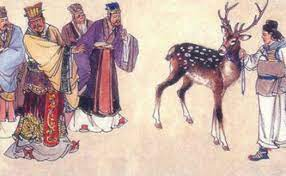



Obviously, the action of Zhao Gao was intentionally reversing black and white and turned the truth upside down. I am sure our computers are not Zhao Gao (unless they are awaiting a revolution!). However, we always have similar results from the classification models between dogs and cats. This time I am going to practice what I learned and train a model with fast ai to classify different animals, but with horse and deer. Let see if my model performs like Zhao Gao.

Here is the main workflow:

1. scraping images
2. input preparation - use **data block api** to create data for **DataLoaders**, which is the data input class in fastai
3. first training for data cleaning
4. creating final model
5. exporting the model as an online application

In Part 1, I will go through steps 1-4 to build up the model and leave the web application setup to Part 2.


In [ ]:
### install fastbook
! pip install -Uqq fastbook

In [ ]:
import fastbook
fastbook.setup_book()
import os
from fastbook import *
from fastai.vision.widgets import *

Mounted at /content/gdrive


## 1. Scraping images

All images for traing will be obtained from the API of [Bing](https://www.bing.com/) as the book did. Therefore, an account at [Microsoft Azure](https://azure.microsoft.com/en-us/free/search/?&ef_id=Cj0KCQjw1a6EBhC0ARIsAOiTkrGR7Qfa_xPz9KezkSSsn0-fYxCOe-KN1U16pG1NjP4kvg_WJno5P34aAoJCEALw_wcB:G:s&OCID=AID2100049_SEM_Cj0KCQjw1a6EBhC0ARIsAOiTkrGR7Qfa_xPz9KezkSSsn0-fYxCOe-KN1U16pG1NjP4kvg_WJno5P34aAoJCEALw_wcB:G:s) is necessary to obtain a key. The free acount allows maximum of 3 transactions per second and 1,000 transactions per month, which is already enough for this project. Below shows the location of the key.

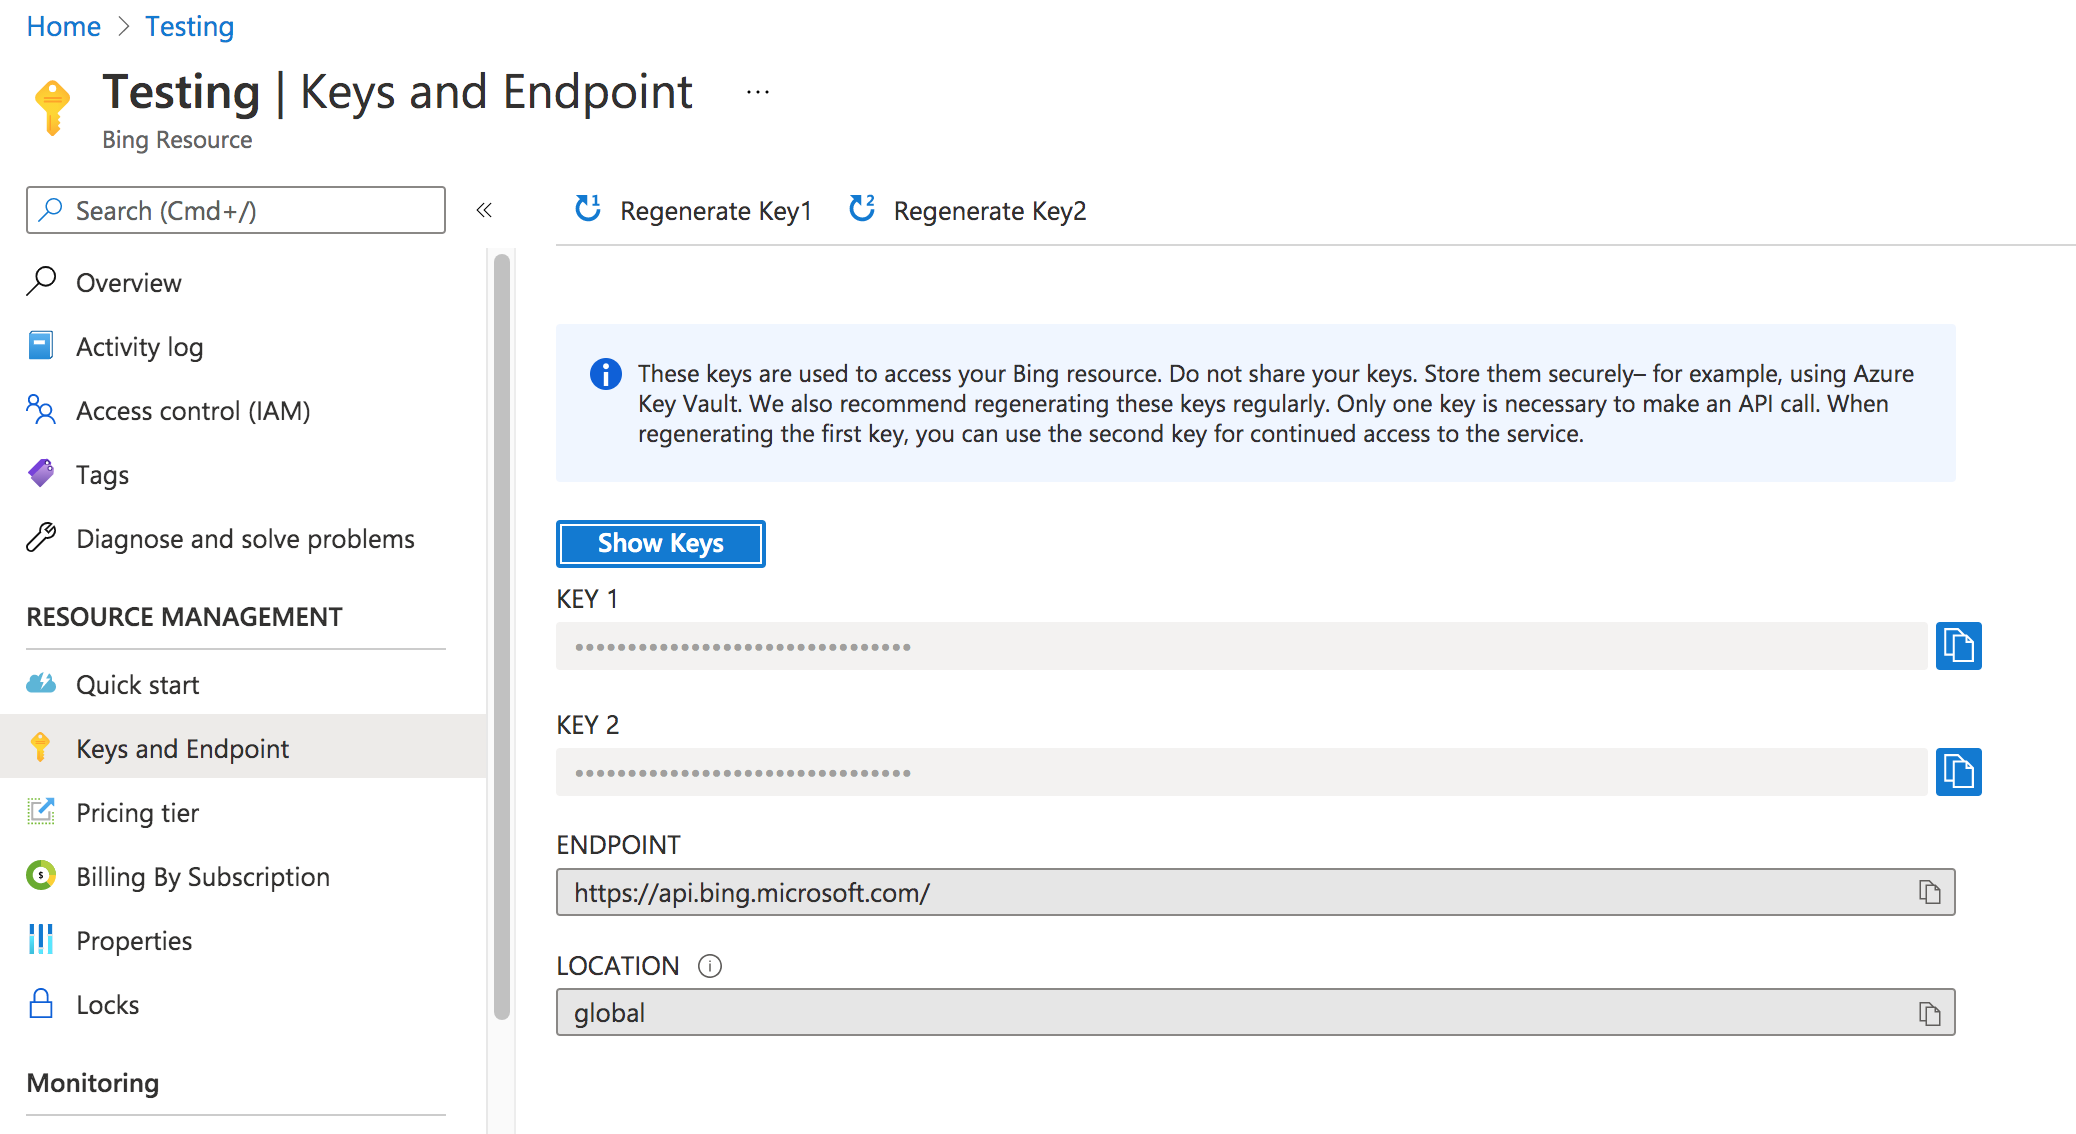

In [ ]:
### download images with Bing Image Search, replace XXX with the key
key = os.environ.get('AZURE_SEARCH_KEY', 'xxx')

Before downloading the images, it is better to grasp the search result on Bing. For example, if I use *orange* to search the fruit *orange* in Bing, some of the results will be the orange color fragment. Lucky, we do not have this problem for *deers* and *horses*.

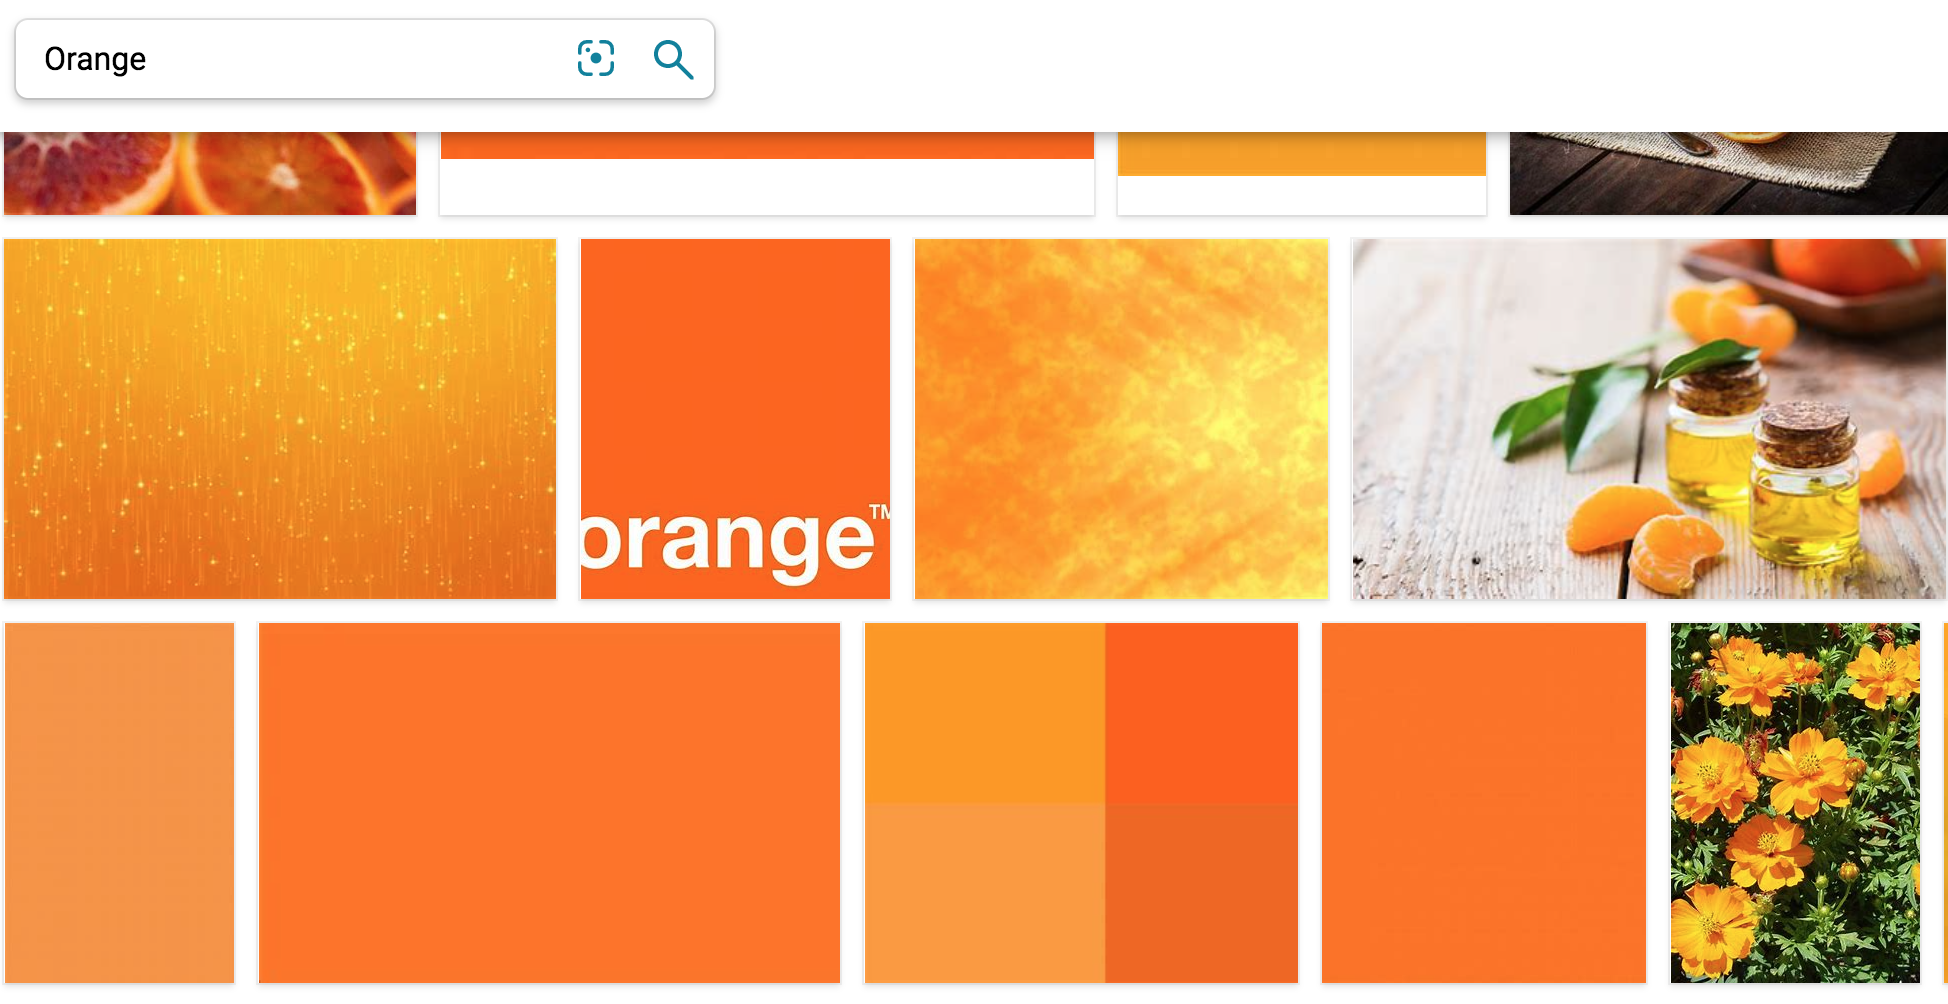

In [ ]:
### set file name according to type
animal = ["horse", "deer"]
path = Path('animal')

All images are saved in separate files. The file's name will be used as the label to classify the images.

In [ ]:
if not path.exists():
    path.mkdir()
for o in animal:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o}')
    download_images(dest, urls=results.attrgot('contentUrl'))
    print(o,'- file created.')

horse - file created.
deer - file created.


Apart from incorrect images, it is also possible that some images are failed during the download process. They should not be included in our model. The function `verify_images` can find out all failed images so that they will be unlinked from the path.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### check and unlink if any failed image
print('Number of failed images:\n')
for o in animal:
  dest = (path/o)
  fns = get_image_files(dest)
  # check for failed images
  failed = verify_images(fns)
  print(o,':',len(failed),'/',len(fns))
  # unlink failed images
  failed.map(Path.unlink)

Number of failed images:

horse : 0 / 144
deer : 2 / 139


## 2. Input preparation

There is a specific class for all the data to be inputted into a fastai model, DataLoaders and I will use DataBlock to create this class. The DataLoaders class will split the data into a training set and validation set. In this case, I split 20% of the data as a validation set. There are 144 images of horses and 137 images of deer available. Therefore, I will apply augmentation to provide more samples.

In [ ]:
animal = DataBlock(
    # assign dependent and independent variable
    blocks=(ImageBlock, CategoryBlock), 
    # provide function to get image files
    get_items=get_image_files, 
    # spliting validation set and random seed
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # provide label to dependent variable
    get_y=parent_label,
    # use random size chop and augmentation to increase data point
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    # use gpu to apply augmentation
    batch_tfms=aug_transforms())

Now the `DataBlock` is ready to load into `DataLoaders`.

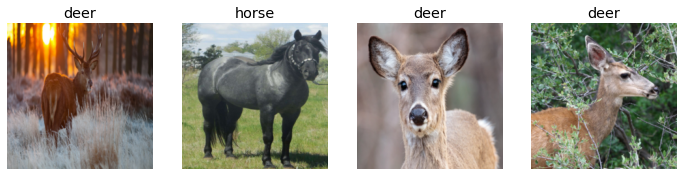

In [ ]:
### show validation set data, default chopping images
dls = animal.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

## 3. first training for data cleaning

Although the above images look perfect, it is still possible a simple way to and find out those results with an incorrect result or a high loss by running a train model.

In [ ]:
### create model
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


The final error rate is 0 with a very low loss, which means all images all correctly classified!

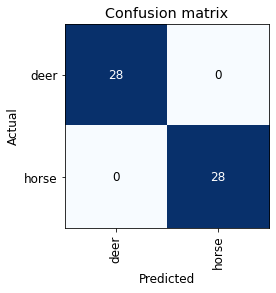

In [ ]:
### confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

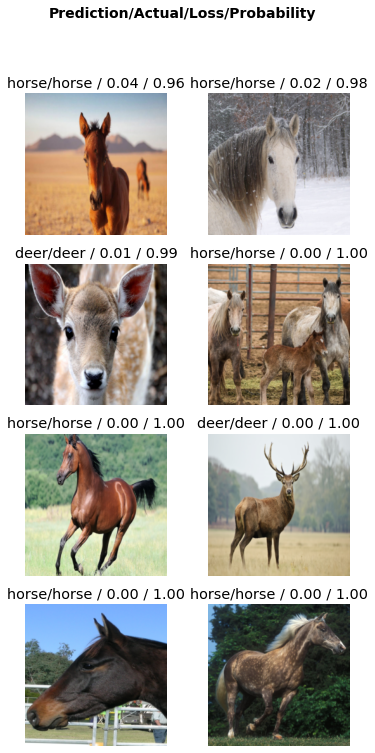

In [ ]:
### show data with the highest loss
interp.plot_top_losses(8, nrows=4)

Our initial model seems to work perfectly and I am happy that my model is not Zhao Gao! Although no further cleaning is necessary, I will still run the GUI for cleaning as a standard workflow.

In [ ]:
### GUI for data cleaning
cleaner = ImageClassifierCleaner(learn)
cleaner

Since the model performs perfectly, I will avoid any unnecessary changes. Otherwise, it would lead to a higher error rate due to overfitting. 

However, when there are any essential updates, the below codes are necessary to activate all changes. 

In [ ]:
### unlink deleted data 
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

### update location
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### update dataloaders due to being lazy objects
dls = animal.dataloaders(path)

## 4. creating final model

As our initial model is already working so good, we will use it as our final model for setting up the web application.

In [ ]:
### create new model and train
final_model = learn

To be contiuned in Part 2...